In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
import torch.nn as nn
import pandas as pd
import torchvision
import albumentations as A
from PIL import Image
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import FCN_ResNet50_Weights
from torchinfo import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(threshold=np.inf)

/home/marcotuliopin/miniconda3/envs/poc/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"GPU Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"GPU Allocated Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU Reserved Memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print("CUDA Version:", torch.version.cuda)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
GPU Total Memory: 6.44 GB
GPU Allocated Memory: 0.00 GB
GPU Reserved Memory: 0.00 GB
CUDA Version: 12.6


Image shape: (530, 730, 3)


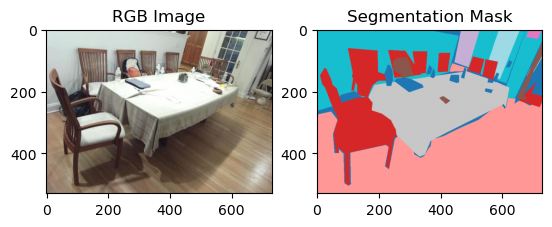

In [3]:
root_dir = "data/SUN_RGBD/"

def print_pair_image_label(image, label) -> None:
    print("Image shape:", np.array(image).shape)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="tab20")
    plt.title("Segmentation Mask")

    plt.show()

print_pair_image_label(Image.open(root_dir + "image/train/img-000001.jpg"), Image.open(root_dir + "label13/train/img13labels-000001.png"))

In [4]:
class SunRGBDDataset(Dataset):
    def __init__(self, path_file, root_dir="", transform=None):
        self.transform = transform
        self.path_df = pd.read_csv(path_file, sep=' ', header=None)
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.path_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.path_df.iloc[idx, 0])
        mask_path = os.path.join(self.root_dir, self.path_df.iloc[idx, 2])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            transformed = self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.long()

        return image, mask

train_transform = A.Compose([
    A.Resize(height=256, width=352, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GridDistortion(p=0.4),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.4),
    A.GaussNoise(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(height=256, width=352, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

/home/marcotuliopin/miniconda3/envs/poc/lib/python3.13/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
train_dataset = SunRGBDDataset(
    path_file=root_dir + "train13.txt",
    root_dir=root_dir,
    transform=train_transform,
)

val_dataset = SunRGBDDataset(
    path_file=root_dir + "split/val13.txt",
    root_dir=root_dir,
    transform=val_transform,
)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [7]:
num_classes = 14
model = torchvision.models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
model.aux_classifier[4] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
)
summary(model, input_size=(4, 3, 256, 352), device=device.type)

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [4, 14, 256, 352]         --
├─IntermediateLayerGetter: 1-1                [4, 2048, 32, 44]         --
│    └─Conv2d: 2-1                            [4, 64, 128, 176]         9,408
│    └─BatchNorm2d: 2-2                       [4, 64, 128, 176]         128
│    └─ReLU: 2-3                              [4, 64, 128, 176]         --
│    └─MaxPool2d: 2-4                         [4, 64, 64, 88]           --
│    └─Sequential: 2-5                        [4, 256, 64, 88]          --
│    │    └─Bottleneck: 3-1                   [4, 256, 64, 88]          75,008
│    │    └─Bottleneck: 3-2                   [4, 256, 64, 88]          70,400
│    │    └─Bottleneck: 3-3                   [4, 256, 64, 88]          70,400
│    └─Sequential: 2-6                        [4, 512, 32, 44]          --
│    │    └─Bottleneck: 3-4                   [4, 512, 32, 44]          379,392

In [8]:
class CheckpointSaver:
    def __init__(self, model, optimizer, save_dir):
        self.model = model
        self.optimizer = optimizer
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def save(self, epoch, verbose=False):
        checkpoint_path = os.path.join(self.save_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, checkpoint_path)
        if verbose:
            print(f"Checkpoint saved at {checkpoint_path}")

    def load(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {checkpoint_path}, starting from epoch {start_epoch}")
        return start_epoch

In [9]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, checkpoint_saver=None):
        self.counter = 0
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.checkpoint_saver = checkpoint_saver

    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss:
            self.checkpoint_saver.save(epoch)
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

In [10]:
class SegmentationTrainer:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train_epoch(self, data_loader, epoch):
        self.model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(data_loader, desc=f"Training Epoch {epoch}"):
            images = images.to(self.device)
            masks = masks.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)['out']
            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            
        total_loss = running_loss / len(data_loader)
        
        return total_loss

    def validate(self, data_loader, epoch):
        self.model.eval()
        running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(data_loader, desc=f"Validation Epoch {epoch}"):
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)['out']
                loss = self.criterion(outputs, masks)

                running_loss += loss.item()
                
        total_loss = running_loss / len(data_loader)
        
        return total_loss


In [ ]:
lr = 1e-4
weight_decay = 1e-3
num_epochs = 50
min_delta = 5e-4
patience = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.1, patience=5
)
checkpoint_saver = CheckpointSaver(model, optimizer, save_dir="checkpoints")
early_stopping = EarlyStopping(
    patience=patience, min_delta=min_delta, checkpoint_saver=checkpoint_saver
)
trainer = SegmentationTrainer(model, optimizer, criterion, device)
train_losses = []
val_losses = []

TypeError: SegmentationTrainer.__init__() takes 5 positional arguments but 6 were given

In [ ]:
for epoch in range(num_epochs):
    train_loss = trainer.train_epoch(train_loader, epoch)
    val_loss = trainer.validate(val_loader, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    
    if early_stopping(val_loss, epoch):
        break


Training Epoch 0:  36%|███▌      | 474/1322 [01:56<03:29,  4.05it/s]


KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(train_losses, val_losses, save_path=None):
    """
    Plota curvas de loss de treino e validação com formatação profissional.
    
    Args:
        train_losses (list): Lista de valores de loss de treino por época.
        val_losses (list): Lista de valores de loss de validação por época.
        save_path (str, optional): Caminho para salvar a figura. Se None, mostra o plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Definindo estilo
    plt.style.use('seaborn-v0_8')
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Plotando as curvas
    train_line, = plt.plot(epochs, train_losses, 
                          color='#1f77b4',  # Azul
                          linewidth=2.5, 
                          marker='o',
                          markersize=8,
                          label='Train Loss')
    
    val_line, = plt.plot(epochs, val_losses, 
                        color='#ff7f0e',  # Laranja
                        linewidth=2.5, 
                        marker='s',
                        markersize=8,
                        label='Validation Loss')
    
    # Ajustes estéticos
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(epochs)
    
    # Adicionando anotação com métricas finais
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    plt.annotate(f'Final Train Loss: {final_train_loss:.4f}\nFinal Val Loss: {final_val_loss:.4f}',
                xy=(0.98, 0.98),
                xycoords='axes fraction',
                ha='right',
                va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend(fontsize=12, framealpha=1)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvo em: {save_path}")
    else:
        plt.show()

In [ ]:
plot_loss_curves(train_losses, val_losses, save_path="loss_curves.png")